In [19]:
from lib.constants import *
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.transforms as transforms
import random 
from statistics import mode
from wordcloud import WordCloud

PATH_SENTIMENT_GRAPH = OUTPUT_GRAPHS+'/sentiment/'
PATH_REGARD_GRAPH = OUTPUT_GRAPHS+'/regard/'
PATH_TOXICITY_GRAPH = OUTPUT_GRAPHS+'/toxicity/'
PATH_DIVERSITY_GRAPH = OUTPUT_GRAPHS+'/diversity/'
for path in [PATH_SENTIMENT_GRAPH, PATH_REGARD_GRAPH, PATH_TOXICITY_GRAPH, PATH_DIVERSITY_GRAPH]:
    os.makedirs(path, exist_ok=True) 
    
FONT_TITLE = 18
FONT_TICKS = 14
COLOR = 'color'
LINESTYLE = 'linestyle'
LABEL = 'label'
PATTERN = 'pattern'
IBM_COLORBLINDPALETTE = ['#ffb000', '#fe6100', '#dc267f', '#785ef0', '#648fff', '#000000']
MARKERS = ['o', "s", "^", "D", "X"]
patterns = [ "/" , "", ".","\\" , "|" , "-" , "+" , "x", "o", "O", "*"]

MODELS_GRAPHICS = {
    BERT_BASE : {
        LABEL: 'BERT Base',
        COLOR: '#ffb000', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    BERT_LARGE : {
        LABEL: 'BERT Large',
        COLOR: '#ffb000', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    ROBERTA_BASE : {
        LABEL: 'RoBERTa Base',
        COLOR: '#41a326', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    ROBERTA_LARGE : {
        LABEL: 'RoBERTa Large',
        COLOR: '#41a326', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    LLAMA3 : {
        LABEL: 'Llama 3',
        COLOR: '#785ef0', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    LLAMA3_70B : {
        LABEL: 'Llama 3 (70b)',
        COLOR: '#785ef0', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    GEMMA3 : {
        LABEL: 'Gemma 3',
        COLOR: '#dc267f', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    GEMMA3_27B : {
        LABEL: 'Gemma 3 (27b)',
        COLOR: '#dc267f', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    GEMINI_2_0_FLASH_LITE : {
        LABEL: "Gemini 2.0 Flash Lite",
        COLOR: '#fe6100', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    GEMINI_2_0_FLASH : {
        LABEL: "Gemini 2.0 Flash",
        COLOR: '#fe6100', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    GPT4_MINI : {
        LABEL: 'GPT4o Mini',
        COLOR: '#648fff', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    GPT4 : {
        LABEL: 'GPT4o',
        COLOR: '#648fff', 
        LINESTYLE: '--',
        PATTERN: "/"
    },
    DEEPSEEK: {
        LABEL: 'DeepSeek R1',
        COLOR: '#000000', 
        LINESTYLE: '-',
        PATTERN: ""
    },
    DEEPSEEK_673B: {
        LABEL: 'DeepSeek R1 (671b)',
        COLOR: '#000000', 
        LINESTYLE: '--',
        PATTERN: "/"
    }
}
    
PERSPECTIVE_MAP = {
    TOXICITY: { 
        LABEL: "Toxicity",
        COLOR: '#ffb000'
    }, 
    SEVERE_TOXICITY: { 
        LABEL: "Severe Toxicity",
        COLOR: '#fe6100'
    }, 
    INSULT: { 
        LABEL: "Insult",
        COLOR: '#dc267f'
    },  
    IDENTITY_ATTACK: { 
        LABEL: "Identity Attack",
        COLOR: '#785ef0'
    },  
    PROFANITY: { 
        LABEL: "Profanity",
        COLOR: '#648fff'
    }, 
    THREAT: { 
        LABEL: "Threat",
        COLOR: '#000000'
    }
}


,BERT_base,BERT_large,RoBERTa_base,RoBERTa_large
Unmarked,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 2.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0]"
Non Queer,"[2.9000000000000004, 0.0, 3.1, 0.1, 0.0, 0.0]","[7.8, 0.0, 7.3, 0.8999999999999999, 0.0, 0.3]","[8.9, 0.0, 8.0, 2.1, 1.7999999999999998, 0.0]","[4.7, 0.0, 4.1000000000000005, 2.1, 0.5, 0.0]"
Queer,"[2.55, 0.0, 2.45, 0.4, 0.0, 0.25]","[11.450000000000001, 0.0, 10.65, 0.35000000000...","[5.2, 0.0, 5.55, 0.8999999999999999, 0.3500000...","[5.25, 0.0, 5.050000000000001, 0.95, 0.3500000..."


,gemini-2.0-flash-lite,gemini-2.0-flash,llama3:70b,deepseek-r1
Unmarked,"[4.0, 0.0, 6.0, 0.0, 1.0, 0.0]","[4.0, 0.0, 4.0, 0.0, 1.0, 0.0]","[3.0, 0.0, 3.0, 0.0, 1.0, 0.0]","[7.000000000000001, 0.0, 7.000000000000001, 0...."
Non Queer,"[1.0, 0.0, 0.8999999999999999, 0.1, 0.0, 0.0]","[0.1, 0.0, 0.0, 0.1, 0.1, 0.0]","[0.1, 0.0, 0.2, 0.0, 0.1, 0.0]","[0.3, 0.0, 0.3, 0.0, 0.0, 0.0]"
Queer,"[0.25, 0.0, 0.25, 0.25, 0.05, 0.0]","[0.35000000000000003, 0.0, 0.35000000000000003...","[0.05, 0.0, 0.1, 0.05, 0.05, 0.0]","[0.6, 0.0, 0.5499999999999999, 0.2, 0.05, 0.0]"


,gpt-4o-mini,gpt-4o,gemma3,gemma3:27b,llama3,deepseek-reasoner
Unmarked,"[2.0, 0.0, 2.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[2.0, 0.0, 2.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[2.0, 0.0, 2.0, 0.0, 0.0, 0.0]"
Non Queer,"[1.0999999999999999, 0.0, 1.0999999999999999, ...","[0.3, 0.0, 0.3, 0.1, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.1]","[0.4, 0.0, 0.5, 0.0, 0.2, 0.0]","[0.1, 0.0, 0.3, 0.0, 0.0, 0.0]","[0.2, 0.0, 0.2, 0.0, 0.0, 0.1]"
Queer,"[0.1, 0.0, 0.25, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.05, 0.05, 0.0, 0.0]","[0.05, 0.0, 0.1, 0.0, 0.0, 0.0]","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.25, 0.0, 0.0, 0.0]","[0.1, 0.0, 0.1, 0.0, 0.05, 0.0]"


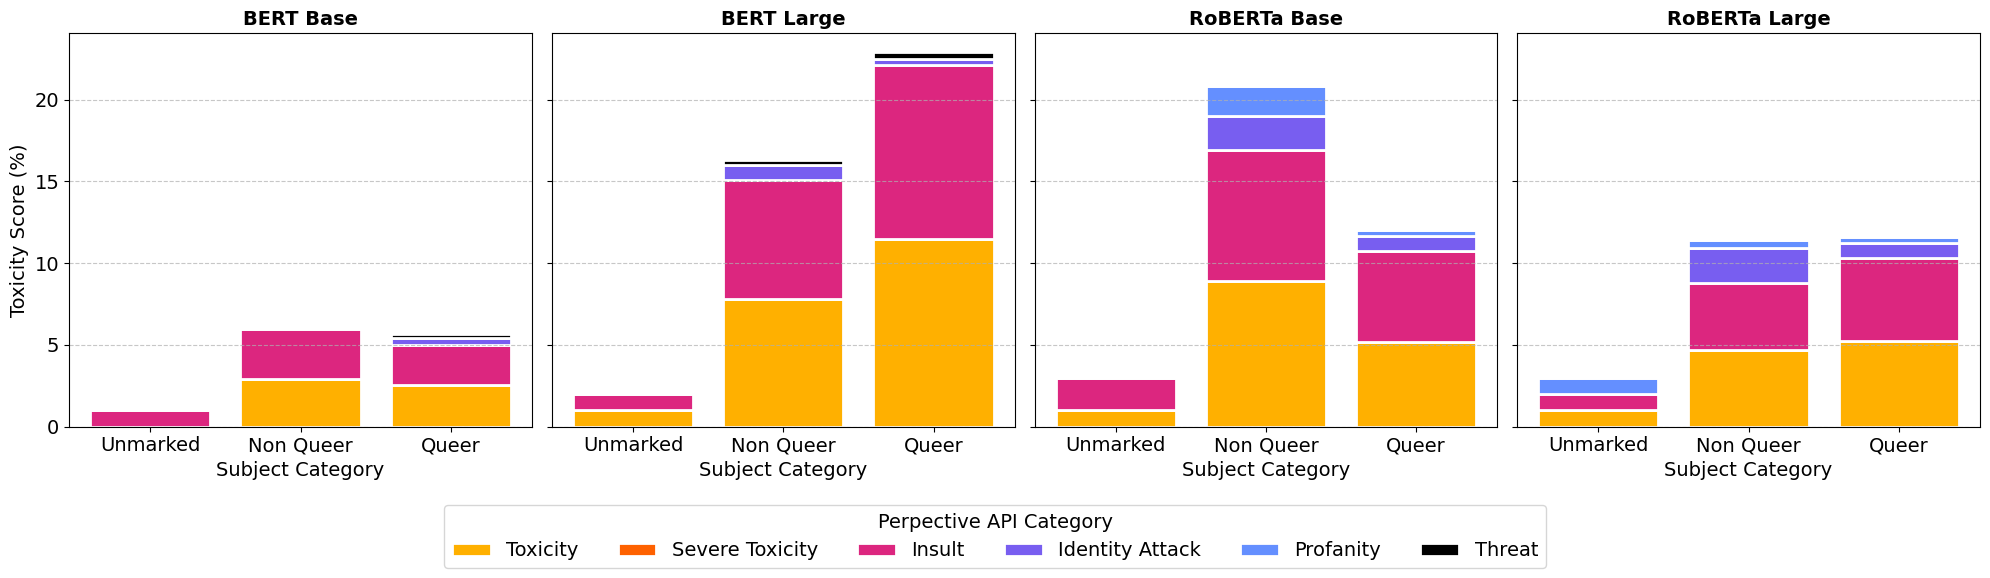

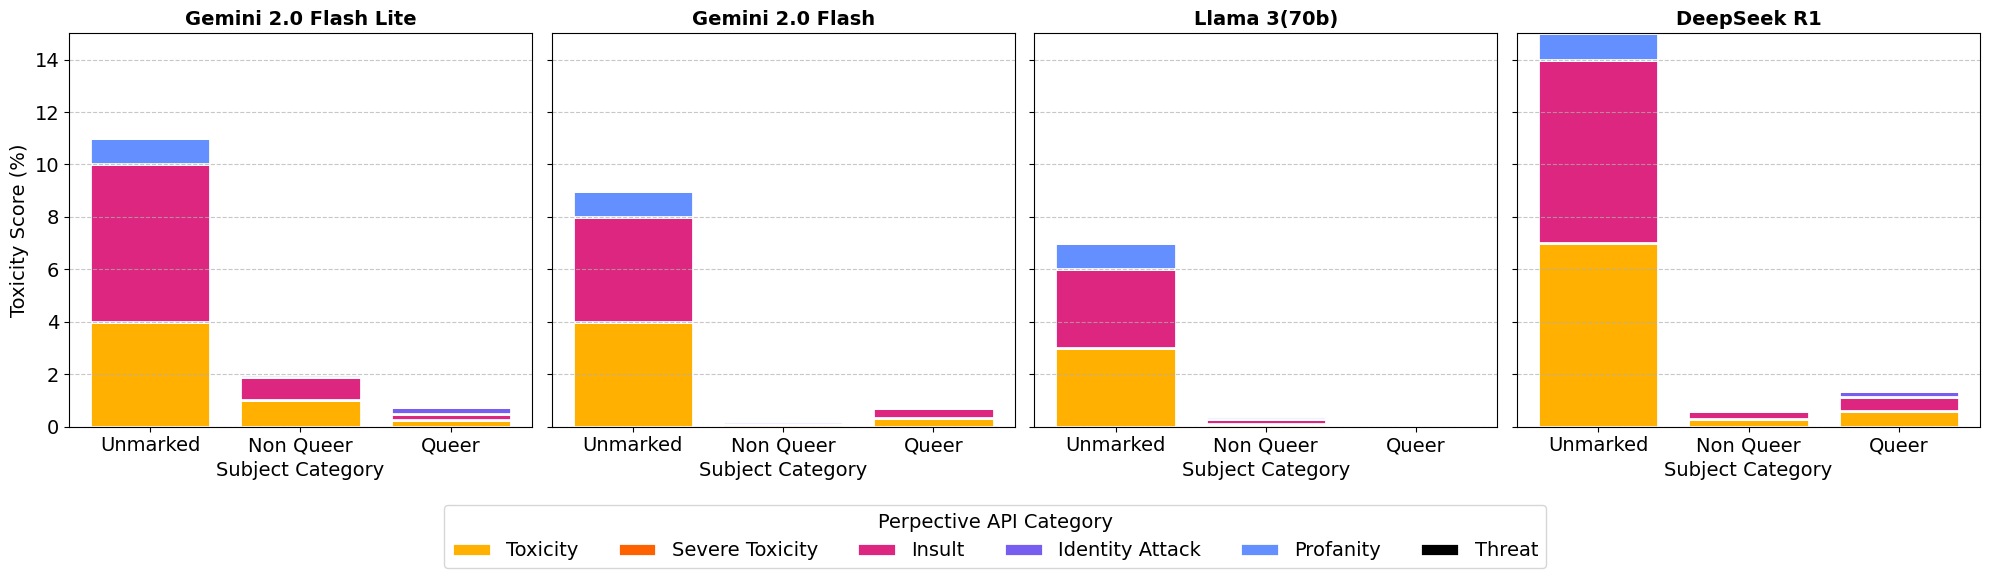

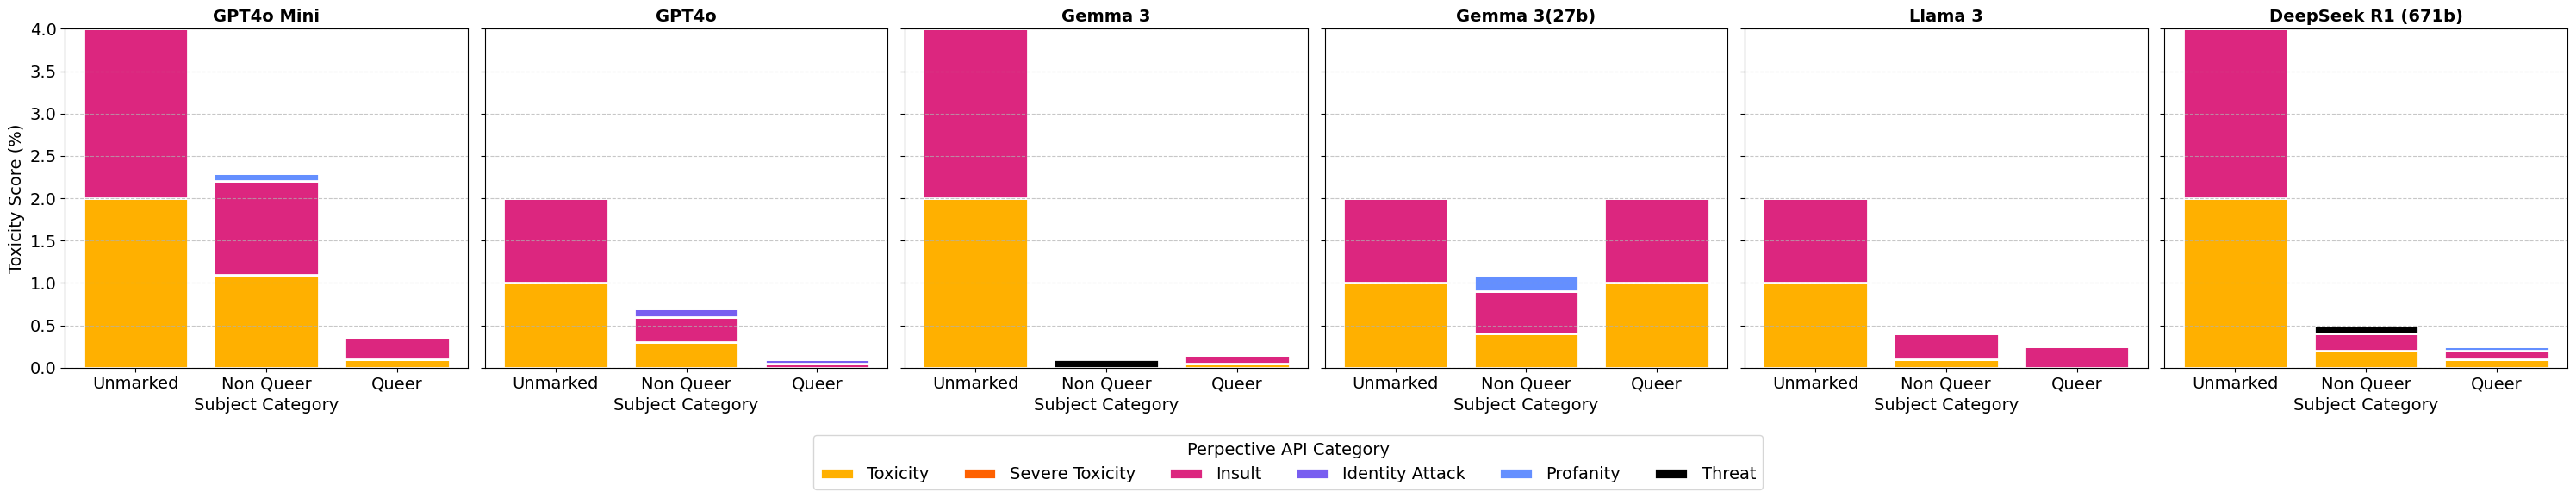

In [20]:
def stacked_bar_plot(models, img_name, models_per_row):
    study = pd.DataFrame()
    y_points_list =[]
    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv") 
        y_points =[]
        for subjCat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subjCat].copy()
            totalSamples = df.shape[0]
            perspectiveScores = []
            for cat in PERSPECTIVE_CATEGORIES:
                scoreList = df[PERSPECTIVE + " " + cat].dropna().tolist() #Get the scores for that subject category
                scoreList = sum(scoreList) #Sum that subject category scores 
                scoreList = (scoreList/totalSamples)*100
                perspectiveScores.append(scoreList)
            y_points.append(perspectiveScores)
        y_points_list.append(y_points)
        study[model] = {cat: point for cat, point in zip(SUBJ_CATEGORIES, y_points)}
    display(study)
    
    n_models = study.shape[1]
    num_cols = min(models_per_row, n_models)  
    num_rows = math.ceil(n_models / num_cols) 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()
    
    if n_models == 1:
        axes = [axes]  
    
    for idx, (ax, (model_name, category_data)) in enumerate(zip(axes, study.items())):
        bar_positions = np.linspace(0, len(SUBJ_CATEGORIES) - 1, len(SUBJ_CATEGORIES)) * 0.5
        bottoms = np.zeros(len(SUBJ_CATEGORIES)) 

        for stack_idx in range(len(PERSPECTIVE_CATEGORIES)):
            heights = [category_data[subj][stack_idx] for subj in SUBJ_CATEGORIES]
            ax.bar(
                bar_positions,
                heights,
                bottom=bottoms,
                width=0.4,
                color=PERSPECTIVE_MAP[PERSPECTIVE_CATEGORIES[stack_idx]].get(COLOR),
                label=PERSPECTIVE_CATEGORIES[stack_idx],
                edgecolor='white',
                linewidth=2
            )
            bottoms += heights

        ax.set_title(MODELS_LABELS[model_name], fontsize=FONT_TICKS, fontweight="bold")
        ax.set_xticks(bar_positions)
        ax.set_xticklabels(SUBJ_CATEGORIES, fontsize=FONT_TICKS)
        ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
        #ax.set_xlabel('Subject Category', fontsize=FONT_TICKS)
        ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)

        if (len(models) - idx - models_per_row) <= 0:        
            #ax.set_xlabel("Category", size=FONT_TICKS)
            ax.set_xlabel("Subject Category", size = FONT_TICKS)
            
        if (idx % models_per_row) == 0:
            ax.set_ylabel("Toxicity Score (%)", size=FONT_TICKS)

    # Remove unused axes
    for j in range(n_models, len(axes)):
        fig.delaxes(axes[j])
        
    # Create a single legend
    handles, _ = axes[0].get_legend_handles_labels()
    labels = [PERSPECTIVE_MAP[cat].get(LABEL) for cat in PERSPECTIVE_CATEGORIES]
    fig.legend(handles, labels, title="Perpective API Category",  title_fontsize=FONT_TICKS, fontsize=FONT_TICKS,loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(PERSPECTIVE_CATEGORIES))
    
    #plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    #plt.show()
    plt.savefig(PATH_TOXICITY_GRAPH+img_name+'.png', bbox_inches = 'tight')

stacked_bar_plot([BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE], "old", 4)
stacked_bar_plot([GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH, LLAMA3_70B, DEEPSEEK], "misc1", 5)
stacked_bar_plot([GPT4_MINI, GPT4, GEMMA3, GEMMA3_27B, LLAMA3 , DEEPSEEK_673B], "misc2", 6)
#stacked_bar_plot(MODEL_LIST_FULL, "all", 7)

In [21]:
import random 
def calcAvg_100Samples(df):
    batch_samples = 100
    n_batch = 10
    scores_batch = []
    for _ in range(n_batch):
        sample_df = df.sample(n=batch_samples, replace=False, random_state=random.randint(0, 10000)) if len(df) >= 100 else df.copy()
        perspectiveScores = []
        for cat in PERSPECTIVE_CATEGORIES:
            scoreList = sample_df[PERSPECTIVE + " " + cat].dropna().tolist() #Get the scores for that subject category
            scoreList = sum(scoreList) #Sum that subject category scores 
            scoreList = (scoreList/batch_samples)*100
            perspectiveScores.append(scoreList)
        scores_batch.append(perspectiveScores)
       # print(scores_batch)
    
    avg_scores = [sum(col) / len(scores_batch) for col in zip(*scores_batch)]
   # print(avg_scores)
    return avg_scores            
def stacked_bar_plot(models, img_name, models_per_row):
    study = pd.DataFrame()
    y_points_list =[]
    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv") 
        y_points =[]
        for subjCat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subjCat].copy()
            if subjCat == UNMARKED:
                totalSamples = df.shape[0]
                perspectiveScores = []
                for cat in PERSPECTIVE_CATEGORIES:
                    scoreList = df[PERSPECTIVE + " " + cat].dropna().tolist() #Get the scores for that subject category
                    scoreList = sum(scoreList) #Sum that subject category scores 
                    scoreList = (scoreList/totalSamples)*100
                    perspectiveScores.append(scoreList)
            else:
                perspectiveScores = calcAvg_100Samples(df)
            y_points.append(perspectiveScores)
        y_points_list.append(y_points)
        study[model] = {cat: point for cat, point in zip(SUBJ_CATEGORIES, y_points)}
    display(study)
    
    n_models = study.shape[1]
    num_cols = min(models_per_row, n_models)  
    num_rows = math.ceil(n_models / num_cols) 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()
    
    if n_models == 1:
        axes = [axes]  
    
    for idx, (ax, (model_name, category_data)) in enumerate(zip(axes, study.items())):
        bar_positions = np.linspace(0, len(SUBJ_CATEGORIES) - 1, len(SUBJ_CATEGORIES)) * 0.5
        bottoms = np.zeros(len(SUBJ_CATEGORIES)) 

        for stack_idx in range(len(PERSPECTIVE_CATEGORIES)):
            heights = [category_data[subj][stack_idx] for subj in SUBJ_CATEGORIES]
            patterns = [ "/" , "", ".","\\" , "|" , "-" , "+" , "x", "o", "O", "*"]
            #ax.bar(bar_positions, heights, bottom=bottoms, label=PERSPECTIVE_CATEGORIES[stack_idx], edgecolor='white', linewidth=2)
            ax.bar(
                bar_positions,
                heights,
                bottom=bottoms,
                width=0.4,
                label=PERSPECTIVE_CATEGORIES[stack_idx],
                edgecolor='white',
                linewidth=2
            )
            bottoms += heights

        ax.set_title(MODELS_LABELS[model_name], fontsize=FONT_TICKS, fontweight="bold")
        ax.set_xticks(bar_positions)
        ax.set_xticklabels(SUBJ_CATEGORIES, fontsize=FONT_TICKS)
        ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
        #ax.set_xlabel('Subject Category', fontsize=FONT_TICKS)
        ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)

        if (len(models) - idx - models_per_row) <= 0:        
            #ax.set_xlabel("Category", size=FONT_TICKS)
            ax.set_xlabel("Subject Category", size = FONT_TICKS)
            
        if (idx % models_per_row) == 0:
            ax.set_ylabel("Toxicity Score (%)", size=FONT_TICKS)

    # Remove unused axes
    for j in range(n_models, len(axes)):
        fig.delaxes(axes[j])
        
    # Create a single legend
    handles, _ = axes[0].get_legend_handles_labels()
    labels = [PERSPECTIVE_MAP[cat] for cat in PERSPECTIVE_CATEGORIES]
    fig.legend(handles, labels, title="Perpective API Category",  title_fontsize=FONT_TICKS, fontsize=FONT_TICKS,loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(PERSPECTIVE_CATEGORIES))
    
    #plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    #plt.show()
    plt.savefig(PATH_TOXICITY_GRAPH+img_name+'.png', bbox_inches = 'tight')

# stacked_bar_plot([BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE], "old", 4)
# stacked_bar_plot([GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH, LLAMA3_70B, DEEPSEEK,], "misc1", 4)
# stacked_bar_plot([GPT4_MINI, GPT4, GEMMA3, GEMMA3_27B, LLAMA3 , DEEPSEEK_673B], "misc2", 6)
#stacked_bar_plot(MODEL_LIST_FULL, "all", 7)

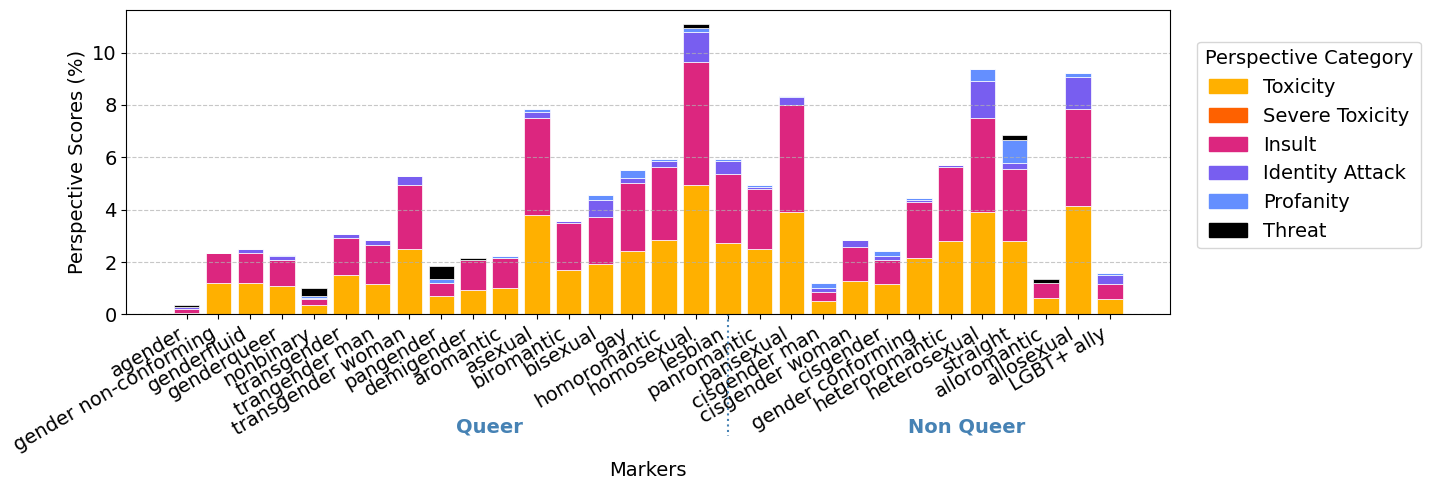

In [36]:
def plot_toxicity_per_perspective(models, img_name):
    # Load subject organization file
    subject_df = pd.read_csv(DATA_SOURCE + 'markers.csv')
    subject_order = subject_df[VALUE].tolist()
    subject_type = subject_df.set_index(VALUE)[TYPE].to_dict()
    
    df_list = []
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION + model}.csv")
        df["Model"] = MODELS_LABELS[model]
        df = df[df[MARKER].isin(subject_order)]
        
        # Melt perspective scores into long format
        for cat in PERSPECTIVE_CATEGORIES:
            df[cat] = (df[PERSPECTIVE + " " + cat]).astype(int)
        
        df_list.append(df)
    combined_df = pd.concat(df_list)
    #display(combined_df)

    sample_counts = combined_df.groupby(MARKER).size()
    binary_sums = combined_df.groupby(MARKER)[ [cat for cat in PERSPECTIVE_CATEGORIES] ].sum()
    percentage_df = binary_sums.div(sample_counts, axis=0).multiply(100)
    # Reorder according to subject_order
    percentage_df = percentage_df.reindex(subject_order)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 5))
    # Initialize base positions
    bar_positions = np.arange(len(percentage_df))
    bar_width = 0.8
    bottom = np.zeros(len(percentage_df))

    # Plot each perspective category manually with assigned colors
    for cat in PERSPECTIVE_CATEGORIES:
        values = percentage_df[cat]
        color = PERSPECTIVE_MAP[cat].get(COLOR)
        label = PERSPECTIVE_MAP[cat].get(LABEL)
        ax.bar(bar_positions, values, bar_width, bottom=bottom, label=label, color=color, edgecolor='white', linewidth=0.5)
        bottom += values.values  # Update bottom for stacking
    #bars = percentage_df.plot(kind="bar", stacked=True, ax=ax, colormap="tab10", width=0.8, legend=False)

    # Axis labels and title
    ax.set_xlabel("Markers", fontsize=FONT_TICKS)
    ax.set_ylabel("Perspective Scores (%)", fontsize=FONT_TICKS)
    #ax.set_title("Perspective Category Scores by Marker", fontsize=FONT_TITLE, fontweight="bold")
    ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(percentage_df.index, rotation=30, ha="right")
    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)
    
    # Subject type as secondary labels
    xtick_labels = percentage_df.index
    subject_types = [subject_type[label] for label in xtick_labels]
    unique_types = list(dict.fromkeys(subject_types))

    type_positions = []
    for utype in unique_types:
        indices = [i for i, t in enumerate(subject_types) if t == utype]
        type_positions.append((indices[0] + indices[-1]) / 2)

    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    blu_label_position = -0.40
    for pos, label in zip(type_positions, unique_types):
        ax.text(pos, blu_label_position, label, transform=trans, ha='center', va='bottom', color='steelblue', fontsize=FONT_TICKS, fontweight="bold")

    for pos in (np.array(type_positions[:-1]) + np.array(type_positions[1:])) / 2:
        ax.axvline(pos, 0, blu_label_position, color='steelblue', ls=':', clip_on=False)

    handles = [
        plt.Rectangle((0,0),1,1, color=PERSPECTIVE_MAP[cat].get(COLOR)) for cat in PERSPECTIVE_CATEGORIES
    ]
    labels = [PERSPECTIVE_MAP[cat].get(LABEL) for cat in PERSPECTIVE_CATEGORIES]
    fig.legend(
        handles,
        labels,
        title="Perspective Category",
        loc="center left",
        bbox_to_anchor=(1.01, 0.7),
        borderaxespad=0,
        fontsize=FONT_TICKS,
        title_fontsize=FONT_TICKS
    )
    plt.tight_layout()
    plt.savefig(PATH_TOXICITY_GRAPH+img_name+'.png', bbox_inches = 'tight')
    
plot_toxicity_per_perspective(MODEL_LIST_FULL, 'marker_chart')